In [21]:
%%capture
!unzip data.zip

In [22]:
!pip install wandb
!wandb login

wandb: Currently logged in as: liuxia62 (jennisleepin). Use `wandb login --relogin` to force relogin


In [23]:
%env WANDB_LOG_MODEL=true
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import math

env: WANDB_LOG_MODEL=true


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [26]:
train_dataset = datasets.ImageFolder('data/train', transform=transform)
val_dataset = datasets.ImageFolder('data/validation', transform=transform)
test_dataset = datasets.ImageFolder('data/test', transform=transform)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust the size based on your pooling and image dimensions
        self.fc2 = nn.Linear(512, len(train_dataset.classes))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Flatten the output for the dense layer
        x = torch.relu(self.fc1(self.dropout(x)))
        x = self.fc2(x)
        return x


In [28]:
class VGG16(nn.Module):
    def __init__(self, num_classes=len(train_dataset.classes)):  # Adjust num_classes based on your dataset
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 7 * 7)  # Flatten before passing to the classifier
        x = self.classifier(x)
        return x


In [19]:
for _ in range(1):
    # 🐝 initialize a wandb run
    wandb.init(
        project="room-clasification",
        config={
            "architecture": "VGG16",
            "epochs": 40,
            "batch_size": 128,
            "lr": 1e-3,
            })

    # Copy your config
    config = wandb.config

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    n_steps_per_epoch = math.ceil(len(train_dataset) / config.batch_size)

    model = VGG16().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for step, (images, labels) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}")

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # the class with the highest score is our prediction
                _, predicted = torch.max(outputs.data, 1)
                total = labels.size(0)
                correct = (predicted == labels).sum().item()

                correct_train += correct
                total_train += total

                tepoch.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

                example_ct += len(images)
                metrics = {
                    "train/train_loss": loss,
                    "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                    "train/example_ct": example_ct
                    }

                if step + 1 < n_steps_per_epoch:
                    # 🐝 Log train metrics to wandb
                    wandb.log(metrics)
                step_ct += 1

            avg_train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train
            train_loss.append(avg_train_loss)
            train_acc.append(train_accuracy)

            print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                .format(epoch+1, config.epochs, avg_train_loss, train_accuracy))

            # Validation
            model.eval()  # Set the model to evaluation mode
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            avg_val_loss = running_val_loss / len(val_loader)
            val_accuracy = 100 * correct_val / total_val
            val_loss.append(avg_val_loss)
            val_acc.append(val_accuracy)

            val_metrics = {
                "val/val_loss": avg_val_loss,
                "val/val_accuracy": val_accuracy
                }
            wandb.log({**metrics, **val_metrics})

            print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
                .format(avg_val_loss, val_accuracy))

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        test_acc = 100 * correct / total
        wandb.summary['test_accuracy'] = test_acc
        print('Accuracy of the network on the test images: {} %'.format(test_acc))

    wandb.finish()

wandb: Currently logged in as: liuxia62 (jennisleepin). Use `wandb login --relogin` to force relogin


Epoch 1: 100%|██████████| 17/17 [00:56<00:00,  3.29s/batch, accuracy=28.9, loss=1.62]


Epoch [1/40], Loss: 1.9650, Accuracy: 25.12%
Validation Loss: 1.5368, Validation Accuracy: 26.42%


Epoch 2: 100%|██████████| 17/17 [00:48<00:00,  2.83s/batch, accuracy=30, loss=1.62]


Epoch [2/40], Loss: 1.6235, Accuracy: 26.75%
Validation Loss: 1.5302, Validation Accuracy: 27.55%


Epoch 3: 100%|██████████| 17/17 [00:49<00:00,  2.92s/batch, accuracy=22.2, loss=1.66]


Epoch [3/40], Loss: 1.6143, Accuracy: 25.96%
Validation Loss: 1.5184, Validation Accuracy: 26.42%


Epoch 4: 100%|██████████| 17/17 [00:48<00:00,  2.86s/batch, accuracy=22.2, loss=1.61]


Epoch [4/40], Loss: 1.6059, Accuracy: 27.13%
Validation Loss: 1.5203, Validation Accuracy: 24.91%


Epoch 5: 100%|██████████| 17/17 [00:48<00:00,  2.86s/batch, accuracy=26.7, loss=1.66]


Epoch [5/40], Loss: 1.6165, Accuracy: 24.84%
Validation Loss: 1.5662, Validation Accuracy: 27.55%


Epoch 6: 100%|██████████| 17/17 [00:49<00:00,  2.92s/batch, accuracy=22.2, loss=1.54]


Epoch [6/40], Loss: 1.6196, Accuracy: 26.43%
Validation Loss: 1.5360, Validation Accuracy: 27.55%


Epoch 7: 100%|██████████| 17/17 [00:48<00:00,  2.83s/batch, accuracy=24.4, loss=1.59]


Epoch [7/40], Loss: 1.6075, Accuracy: 25.40%
Validation Loss: 1.5317, Validation Accuracy: 24.91%


Epoch 8: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=27.8, loss=1.62]


Epoch [8/40], Loss: 1.6370, Accuracy: 26.33%
Validation Loss: 1.5537, Validation Accuracy: 24.91%


Epoch 9: 100%|██████████| 17/17 [00:48<00:00,  2.88s/batch, accuracy=17.8, loss=1.69]


Epoch [9/40], Loss: 1.6351, Accuracy: 25.07%
Validation Loss: 1.5172, Validation Accuracy: 27.55%


Epoch 10: 100%|██████████| 17/17 [00:49<00:00,  2.92s/batch, accuracy=31.1, loss=1.6]


Epoch [10/40], Loss: 1.6336, Accuracy: 26.71%
Validation Loss: 1.5874, Validation Accuracy: 27.55%


Epoch 11: 100%|██████████| 17/17 [00:47<00:00,  2.81s/batch, accuracy=33.3, loss=1.55]


Epoch [11/40], Loss: 1.6121, Accuracy: 26.24%
Validation Loss: 1.4873, Validation Accuracy: 27.55%


Epoch 12: 100%|██████████| 17/17 [00:48<00:00,  2.82s/batch, accuracy=26.7, loss=1.64]


Epoch [12/40], Loss: 1.6099, Accuracy: 26.19%
Validation Loss: 1.5162, Validation Accuracy: 27.55%


Epoch 13: 100%|██████████| 17/17 [00:48<00:00,  2.86s/batch, accuracy=23.3, loss=1.65]


Epoch [13/40], Loss: 1.6138, Accuracy: 26.99%
Validation Loss: 1.5147, Validation Accuracy: 27.55%


Epoch 14: 100%|██████████| 17/17 [00:49<00:00,  2.89s/batch, accuracy=26.7, loss=1.67]


Epoch [14/40], Loss: 1.6079, Accuracy: 27.22%
Validation Loss: 1.5300, Validation Accuracy: 27.55%


Epoch 15: 100%|██████████| 17/17 [00:47<00:00,  2.81s/batch, accuracy=32.2, loss=1.63]


Epoch [15/40], Loss: 1.6050, Accuracy: 26.99%
Validation Loss: 1.5037, Validation Accuracy: 27.55%


Epoch 16: 100%|██████████| 17/17 [00:49<00:00,  2.90s/batch, accuracy=27.8, loss=1.57]


Epoch [16/40], Loss: 1.6050, Accuracy: 27.13%
Validation Loss: 1.5207, Validation Accuracy: 27.55%


Epoch 17: 100%|██████████| 17/17 [00:47<00:00,  2.82s/batch, accuracy=27.8, loss=1.58]


Epoch [17/40], Loss: 1.6073, Accuracy: 26.19%
Validation Loss: 1.5224, Validation Accuracy: 27.55%


Epoch 18: 100%|██████████| 17/17 [00:47<00:00,  2.80s/batch, accuracy=31.1, loss=1.62]


Epoch [18/40], Loss: 1.6075, Accuracy: 27.92%
Validation Loss: 1.4992, Validation Accuracy: 27.55%


Epoch 19: 100%|██████████| 17/17 [00:48<00:00,  2.85s/batch, accuracy=17.8, loss=1.66]


Epoch [19/40], Loss: 1.6070, Accuracy: 25.96%
Validation Loss: 1.5293, Validation Accuracy: 27.55%


Epoch 20: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=23.3, loss=1.64]


Epoch [20/40], Loss: 1.6059, Accuracy: 27.22%
Validation Loss: 1.5220, Validation Accuracy: 27.55%


Epoch 21: 100%|██████████| 17/17 [00:47<00:00,  2.82s/batch, accuracy=26.7, loss=1.63]


Epoch [21/40], Loss: 1.6061, Accuracy: 26.61%
Validation Loss: 1.5240, Validation Accuracy: 27.55%


Epoch 22: 100%|██████████| 17/17 [00:48<00:00,  2.83s/batch, accuracy=27.8, loss=1.53]


Epoch [22/40], Loss: 1.6031, Accuracy: 27.88%
Validation Loss: 1.5131, Validation Accuracy: 27.55%


Epoch 23: 100%|██████████| 17/17 [00:48<00:00,  2.88s/batch, accuracy=21.1, loss=1.59]


Epoch [23/40], Loss: 1.6044, Accuracy: 26.52%
Validation Loss: 1.5225, Validation Accuracy: 27.55%


Epoch 24: 100%|██████████| 17/17 [00:47<00:00,  2.80s/batch, accuracy=24.4, loss=1.59]


Epoch [24/40], Loss: 1.6049, Accuracy: 25.30%
Validation Loss: 1.5135, Validation Accuracy: 27.55%


Epoch 25: 100%|██████████| 17/17 [00:47<00:00,  2.80s/batch, accuracy=25.6, loss=1.5]


Epoch [25/40], Loss: 1.6048, Accuracy: 28.86%
Validation Loss: 1.5176, Validation Accuracy: 27.55%


Epoch 26: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=21.1, loss=1.59]


Epoch [26/40], Loss: 1.6046, Accuracy: 27.36%
Validation Loss: 1.5187, Validation Accuracy: 27.55%


Epoch 27: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=23.3, loss=1.64]


Epoch [27/40], Loss: 1.6046, Accuracy: 25.44%
Validation Loss: 1.5068, Validation Accuracy: 26.42%


Epoch 28: 100%|██████████| 17/17 [00:47<00:00,  2.80s/batch, accuracy=30, loss=1.47]


Epoch [28/40], Loss: 1.6030, Accuracy: 27.08%
Validation Loss: 1.5190, Validation Accuracy: 27.55%


Epoch 29: 100%|██████████| 17/17 [00:47<00:00,  2.80s/batch, accuracy=35.6, loss=1.49]


Epoch [29/40], Loss: 1.6046, Accuracy: 27.08%
Validation Loss: 1.5175, Validation Accuracy: 27.55%


Epoch 30: 100%|██████████| 17/17 [00:48<00:00,  2.88s/batch, accuracy=24.4, loss=1.57]


Epoch [30/40], Loss: 1.6064, Accuracy: 25.87%
Validation Loss: 1.5133, Validation Accuracy: 27.55%


Epoch 31: 100%|██████████| 17/17 [00:48<00:00,  2.83s/batch, accuracy=27.8, loss=1.57]


Epoch [31/40], Loss: 1.6038, Accuracy: 25.77%
Validation Loss: 1.5230, Validation Accuracy: 27.55%


Epoch 32: 100%|██████████| 17/17 [00:47<00:00,  2.81s/batch, accuracy=26.7, loss=1.72]


Epoch [32/40], Loss: 1.6072, Accuracy: 26.80%
Validation Loss: 1.5158, Validation Accuracy: 27.55%


Epoch 33: 100%|██████████| 17/17 [00:47<00:00,  2.81s/batch, accuracy=31.1, loss=1.55]


Epoch [33/40], Loss: 1.6046, Accuracy: 26.80%
Validation Loss: 1.5246, Validation Accuracy: 27.55%


Epoch 34: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=30, loss=1.61]


Epoch [34/40], Loss: 1.6060, Accuracy: 26.05%
Validation Loss: 1.5121, Validation Accuracy: 27.55%


Epoch 35: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=30, loss=1.63]


Epoch [35/40], Loss: 1.6058, Accuracy: 27.22%
Validation Loss: 1.5161, Validation Accuracy: 27.55%


Epoch 36: 100%|██████████| 17/17 [00:47<00:00,  2.82s/batch, accuracy=28.9, loss=1.55]


Epoch [36/40], Loss: 1.6054, Accuracy: 26.47%
Validation Loss: 1.5199, Validation Accuracy: 27.55%


Epoch 37: 100%|██████████| 17/17 [00:48<00:00,  2.86s/batch, accuracy=33.3, loss=1.57]


Epoch [37/40], Loss: 1.6050, Accuracy: 26.71%
Validation Loss: 1.5163, Validation Accuracy: 27.55%


Epoch 38: 100%|██████████| 17/17 [00:48<00:00,  2.87s/batch, accuracy=25.6, loss=1.56]


Epoch [38/40], Loss: 1.6038, Accuracy: 27.17%
Validation Loss: 1.5217, Validation Accuracy: 27.55%


Epoch 39: 100%|██████████| 17/17 [00:48<00:00,  2.84s/batch, accuracy=28.9, loss=1.54]


Epoch [39/40], Loss: 1.6046, Accuracy: 26.94%
Validation Loss: 1.5183, Validation Accuracy: 27.55%


Epoch 40: 100%|██████████| 17/17 [00:48<00:00,  2.88s/batch, accuracy=28.9, loss=1.52]


Epoch [40/40], Loss: 1.6049, Accuracy: 26.38%
Validation Loss: 1.5132, Validation Accuracy: 27.55%
Accuracy of the network on the test images: 27.106227106227106 %


train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▂▁▂▂▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁
val/val_accuracy,▅█▅▁██▁▁██████████████████▅█████████████
val/val_loss,▄▄▃▃▇▄▄▆▃█▁▃▃▄▂▃▃▂▄▃▄▃▃▃▃▃▂▃▃▃▃▃▄▃▃▃▃▃▃▃
test_accuracy,27.10623
train/epoch,40.0
train/example_ct,85520
train/train_loss,1.52267
val/val_accuracy,27.54717
val/val_loss,1.51321


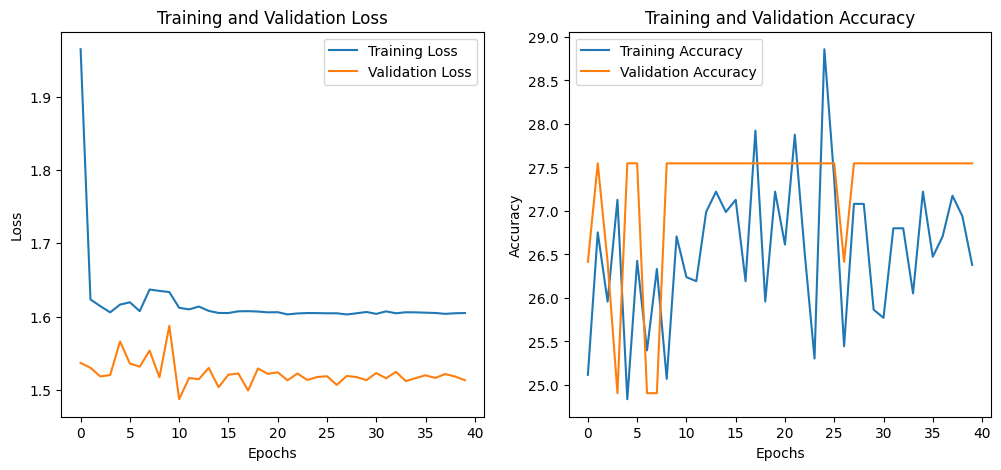

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()